In [536]:
import pandas as pd
import MyLib.nlp as nlp
from MyLib.nlp import current_time as t
import MyLib.HTML_prep as HTML_prep
import MyLib.analysis as analysis 
import MyLib.hype2 as hype 
from ipywidgets import interactive, interact

from tqdm import tqdm
tqdm.pandas()
# allows for progress_apply

%load_ext autoreload
%autoreload 2

def d(l):
    pd.set_option('display.max_colwidth', l)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import Files & group by date


In [544]:
text_column="sentences"

#df=pd.read_json("2023-08-02_ChatGPT_Paragraphs_NLP-Out.json")
df=pd.read_json("2023-09-08GPT3_sentiment_metaphor_modal_detection.json")

In [545]:
df

,key,url,filename,Uni,date,itemType,filepath,links,HTML,sentences,...,capitalism,replacement,edu,anthropomorphism,learning,privacy,promise,discrimination,sentiment_n,modal_info
36158,KB9PEGPE,,dpia-zoom-25-february-2022_0.pdf,surf,2022-03-14 00:00:00,document,C:\Users\mr\Zotero\storage\KB9PEGPE\dpia-zoom-25-february-2022_0.pdf,[],False,https://edpb.europa.eu/system/files/2021-.,...,None,None,None,None,None,None,None,None,0,[]
38654,WX4G68MK,,hosa-domainarchitecture-iam-v1.0-eng-gb-final.pdf,surf,2023-06-02 00:00:00,document,C:\Users\mr\Zotero\storage\WX4G68MK\hosa-domainarchitecture-iam-v1.0-eng-gb-final.pdf,[],False,The higher education card enables the holder to provide only the data needed for onboarding.,...,None,None,[higher education],[card],[education],None,None,None,0,[]
9062,Z9MHGMM2,https://transmissioninmotion.sites.uu.nl/the-ethics-of-ambiguous-ai-dominique-ubbels/,the-ethics-of-ambiguous-ai-dominique-ubbels.html,Utrecht University,2023-01-01 00:00:00,webpage,C:\Users\mr\Zotero\storage\Z9MHGMM2\the-ethics-of-ambiguous-ai-dominique-ubbels.html,"[#_ftn1, #_ftn2, #_ftnref1, #_ftnref2, https://twitter.com/intent/tweet?text=The%20Ethics%20of%20Ambiguous%20AI%20%E2%80%93%20Dominique%20Ubbels&url=https://transmissioninmotion.sites.uu.nl/the-ethics-of-ambiguous-ai-dominique-ubbels/&, https://plus.google.com/share?url=https://transmissioninmotion.sites.uu.nl/the-ethics-of-ambiguous-ai-dominique-ubbels/, https://www.linkedin.com/shareArticle?mini=true&url=https://transmissioninmotion.sites.uu.nl/the-ethics-of-ambiguous-ai-dominique-ubbels/&title=The%20Ethics%20of%20Ambiguous%20AI%20%E2%80%93%20Dominique%20Ubbels&source=Transmission%20in%2...",True,"Often, it’s designed to serve the same good–or rejected as it disturbs what was good.",...,None,None,None,None,None,None,None,None,-1,[]
11051,8DWZCN6K,https://www.eur.nl/en/about-eur/vision/community-learning-and-innovation/ai-tools-education,ai-tools-education.html,Rotterdam University,2023-04-26 00:00:00,webpage,C:\Users\mr\Zotero\storage\8DWZCN6K\ai-tools-education.html,"[None, None, None, https://www.eur.nl/en/about-eur/organisation-administration/legal-affairs/legal-protection/board-appeals-examinations/contact-examination-boards, https://www.eur.nl/en/about-eur/policy-and-regulations/regulations-and-guidelines/cheating-and-plagiarism, None, https://www.eur.nl/en/news-calendar/dossiers/artificial-intelligence, https://www.eur.nl/en/research/research-initiatives/erasmus-initiatives/societal-impact-ai/study-programmes-courses, https://my.eur.nl/en/rsm-employee/chatgpt, https://www.surf.nl/en/artificial-intelligence-machine-learning, https://feedbackfruits....",True,"ChatGPT is now a well-known example of this, but numerous other examples can be found.",...,None,None,"[exam, exam]",None,None,None,None,None,0,[can]
38678,WX4G68MK,,hosa-domainarchitecture-iam-v1.0-eng-gb-final.pdf,surf,2023-06-02 00:00:00,document,C:\Users\mr\Zotero\storage\WX4G68MK\hosa-domainarchitecture-iam-v1.0-eng-gb-final.pdf,[],False,The digital enrolment process at the education institution allows for the individual's identity to be.,...,None,None,[education],None,[education],None,None,None,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42139,ALDWBD7G,,promises-of-ai-in-education-june-2022-def2.pdf,surf,2022-07-08 00:00:00,document,C:\Users\mr\Zotero\storage\ALDWBD7G\promises-of-ai-in-education-june-2022-def2.pdf,[],False,"Confusion reports automatically summarise the most important areas considered by AI where either reading or video analysis caused confusion or was not clear to students.32 Perusall, effectively, “automatically mines questions that students are asking about a particular reading assignment and, using a topic-modelling algorithm, groups questions into three to four conceptual areas of confusion”.33 Reports like these require data about where students spend time on a page, what they answer for annotations, and whether they are getting through th

In [539]:
#df["key_context"]=sentence_context(df, txt_column="key")
df["sentence_context"]=analysis.sentence_context(df, txt_column="sentences")
df[df["sentence_context"]==""]

,key,url,filename,Uni,date,itemType,filepath,links,HTML,sentences,...,capitalism,replacement,edu,anthropomorphism,learning,privacy,promise,discrimination,sentiment_n,modal_info
9930,JZYV32HZ,https:...,whethe...,Utrech...,2023-05-03,webpage,C:\Use...,[https...,True,“Wheth...,...,None,None,[Unive...,None,None,None,None,None,0,[]
10998,YK3BDLRD,https:...,four-q...,Rotter...,2023-04-25,webpage,C:\Use...,[http:...,True,Four Q...,...,[Busin...,None,None,None,None,None,None,None,0,[]
15262,TU5PJUZF,https:...,alp-st...,Vrije ...,2023-04-20,webpage,C:\Use...,[https...,True,ALP st...,...,[inves...,None,[teach...,None,None,None,None,None,0,[]
8643,VSVLDI9W,https:...,bots-o...,Utrech...,2023-02-20,webpage,C:\Use...,[https...,True,Bots o...,...,None,None,[Unive...,None,None,None,None,None,0,[]
26108,XF3WUE7M,https:...,ai-off...,Univer...,NaT,webpage,C:\Use...,[https...,True,AI off...,...,None,None,[teach...,None,[Learn...,None,None,None,1,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23903,QX27XTY5,https:...,de-lin...,Delft ...,2023-05-24,webpage,C:\Use...,[https...,True,.. Mor...,...,None,None,None,None,None,None,None,None,1,[]
16039,QFBZTLS7,https:...,stage-...,Tilbur...,2016-04-28,webpage,C:\Use...,[https...,True,Intern...,...,None,None,[acade...,None,None,None,None,None,1,[]
15991,QFBZTLS7,https:...,stage-...,Tilbur...,2016-04-28,webpage,C:\Use...,[https...,True,Intern...,...,None,None,[acade...,None,None,None,None,None,1,[]
2160,4NWFRQH7,https:...,ai-in-...,Radbou...,2023-04-19,webpage,C:\Use...,[https...,True,Contac...,...,None,None,[Teach...,None,None,None,None,None,0,[]


In [540]:

df["modal"]=df["modal_info"]
df["modal_n"] = df.modal.apply(lambda x: len(x))     

In [542]:
d(600)
df[(df["modal_n"]==1) & (df["subjunctive_n"]>0)][["sentences","subjunctive","modal"]]

,sentences,subjunctive,modal
15290,"Their aim is to establish if it can be done, becoming friends with a chatbot.",[aim],[can]
44858,These experiments even yield new ideas that one probably would not have expected in theory.,[expected],[would]
49463,The expectation for 2027 is that the use of video in education will continue.,[expectation],[will]
5284,.... Forbes 30 under 30... Did you expect you would be in the Forbes 30 under 30.,[expect],[would]
49457,"of videos and knowledge clips, the expectation at many institutions is that this experience will last.",[expectation],[will]
...,...,...,...
52089,"During the 25th edition, we want to inspire participants to look ahead and outline the educational developments that will become relevant in the coming years.",[want],[will]
615,INtoEAT aims at development and implementation of innovative digital tools that can improve healthy eating habits and lifestyle in the elderly as a nutrition aid.,[aims],[can]
899,Anyone who wants to untangle the various crises in the Netherlands would do well to find out exactly what is going on and what solutions are available.,[wants],[would]
1835,"By exploring how AI can complement and enhance writing skills, we aim to alleviate these concerns and empower students and staff to use AI effectively to improve their writing productivity and quality.",[aim],[can]


In [543]:
relevant_columns=["Uni", "date", "sentences","word_count","NoStopwords","metaphors",'sentiment',"modal","url","key"]

df[relevant_columns].to_json("2023-09-10_ChatGPT_reduced_dataset.json")

In [9]:
GROUP_key="Uni"

Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="key").value_counts(GROUP_key), 
                     text_column:df.value_counts(GROUP_key)})
Counts[text_column].describe()

count    15.000000
mean     2373.9...
std      5081.4...
min      339.00...
25%      572.50...
50%      1308.0...
75%      1494.0...
max      20660....
Name: sentences, dtype: float64

In [10]:
GROUP_key="Uni"

df.loc[:,"translated"]=0
df.loc[df.source_language!="en","translated"]=1

Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="key").value_counts(GROUP_key), 
                     text_column:df.value_counts(GROUP_key),
                     f"translated_{text_column}":df.groupby(GROUP_key)["translated"].sum(),
                     "translated_P":df.drop_duplicates(subset="key").groupby(GROUP_key)["translated"].sum()})

Counts["sentences_per_publ"]=Counts[text_column]/Counts["publications"]
Counts[f"share_translated_{text_column}"]=Counts[f"translated_{text_column}"]/Counts[text_column]
Counts["share_translated_P"]=Counts["translated_P"]/Counts["publications"]

Counts.sort_values("sentences_per_publ", ascending=False)

,publications,sentences,translated_sentences,translated_P,sentences_per_publ,share_translated_sentences,share_translated_P
Uni,,,,,,,
surf,41,20660,10455,27,503.90...,0.506050,0.658537
Tilburg University,21,1038,304,7,49.428571,0.292871,0.333333
Eindhoven University of Technoloy,35,1701,691,21,48.600000,0.406232,0.600000
Maastricht Univerisity,33,1565,209,13,47.424242,0.133546,0.393939
Vrije Universiteit Amsterdam,36,1682,229,6,46.722222,0.136147,0.166667
University of Amsterdam,31,1420,577,13,45.806452,0.406338,0.419355
Delft University,22,983,626,12,44.681818,0.636826,0.545455
Radboud Nijmegen,37,1421,720,18,38.405405,0.506685,0.486486
Wageningen University,9,339,103,3,37.666667,0.303835,0.333333


In [11]:
freq="M"
#df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")

df_publ=df.drop_duplicates(subset=text_column)[["date","key"]]
df_publ=df_publ.set_index("date").groupby(pd.Grouper(freq=freq)).count()
df_publ.columns=[text_column]
df_publ.tail()

,sentences
date,
2023-04-30,1548
2023-05-31,3881
2023-06-30,6315
2023-07-31,2630
2023-08-31,29


In [12]:
# Rebuild Fulltext Dataframe (if needed)

d(40)
df_P=pd.DataFrame({"text": df.groupby("key")[text_column].apply(' '.join)})
df_P[["NoStopwords","links"]]=df.groupby("key")[["NoStopwords","links"]].sum()
df_P=df_P.merge(df[["key","url","filepath","Uni","date","HTML"]],right_on="key",left_on="key",how="right").drop_duplicates("key")
df_P.head(4)

,key,text,NoStopwords,links,url,filepath,Uni,date,HTML
0,KB9PEGPE,https://edpb.europa.eu/system/files/...,[weiteredokumentevladekrechtsgutacht...,[],,C:\Users\mr\Zotero\storage\KB9PEGPE\...,surf,2022-03-14,False
1,ALDWBD7G,https://comproved.com/. https://www....,"[link, credit, author, question, num...",[],,C:\Users\mr\Zotero\storage\ALDWBD7G\...,surf,2022-07-08,False
3,38A47Z3B,https://qnamaker.ai. https://www.sub...,"[securityindexhtml, operatingsystem,...",[],,C:\Users\mr\Zotero\storage\38A47Z3B\...,surf,2018-10-16,False
13,8AWPG27Z,www.surf.nlwww.surf.nl/techtrends. #...,"[efficiency, netherlandseurope, eart...","[http://www.surf.nl, https://www.sur...",,C:\Users\mr\Zotero\storage\8AWPG27Z\...,surf,2023-05-08,False


# 2. Most common words

In [13]:

df["NoStopwords_Set"]=df.NoStopwords.apply(lambda x: list(x))
Lists=df.NoStopwords_Set.to_list()
len(Lists)

35610

[('datum', 2819), ('ai', 2819), ('student', 2101), ('education', 2062), ('chatgpt', 1643), ('use', 1574), ('research', 1272), ('zoom', 1268), ('work', 1209), ('university', 1120), ('new', 1045), ('technology', 1001), ('information', 970), ('digital', 967), ('learn', 962), ('system', 931), ('model', 885), ('example', 885), ('learning', 881), ('user', 796)]


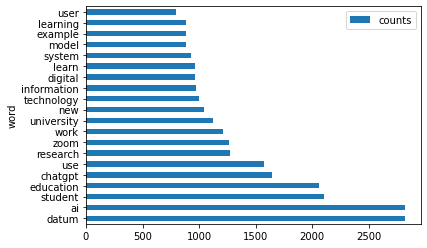

In [14]:
Lists=df.NoStopwords.to_list()

Lists=[i for i in Lists if i!=None]
Words=[item for sublist in Lists for item in sublist]

from collections import Counter
a_counter = Counter(Words)
most_common = a_counter.most_common(20)

print(most_common)#, most_common2)
pd.DataFrame.from_records(most_common,columns=["word","counts"],index="word").plot.barh()
pd.DataFrame(most_common,columns=["word","counts"]).to_excel("most_common_words.xlsx")

# Finding the most hyping universities, articles, and sentences

In [17]:
# Load the wordlists from the hype module.

text_column="sentence_context"
#OR
text_column="sentences"

WordLists=list(hype.WordListDict.keys())

n_examples=5

most_commons={}

for wordList in WordLists:
    wordlist=hype.WordListDict[wordList]
    df[wordList]=df[text_column].apply(hype.hype_word,keys=wordlist)
    df[wordList+"_n"]=df[wordList].apply(lambda x: len(x) if isinstance(x,list) else 0)

    # make a list mit most-common words
    most_commons[wordList]=df[wordList].explode().dropna().value_counts()

    print(f"\n ---> {wordList} <--- \n")
    print("3 most common key-words: ")
    print(most_commons[wordList][:3])

    example=df[(df.word_count>12) & (df.word_count<20)].sort_values(wordList+"_n", ascending=False).head(n_examples)
    example[[wordList,wordList+"_n"]]

    for n, i in enumerate(example[text_column]):
        print(f"\n example {n+1}: ", i)

# add the column for metaphors & sentiment
df["metaphors_n"]=df["metaphors"].apply(lambda x: len(x) if isinstance(x,list) else 0)
df["sentiment_n"]=df.sentiment.replace("neutral",0).replace("positive",1).replace("negative",-1)


df.head()

mod_words=df.filter(regex=f"_{text_column}", axis=1).dropna(how="all")
mod_words_n=df.filter(regex="_n", axis=1).dropna(how="all")


 ---> predictive <--- 

3 most common key-words: 
predictive
can     3150
will    1943
may      543
Name: count, dtype: int64

 example 1:  In five years the language will have changed, we will have changed and this system will be outdated.

 example 2:  Zoom may cease to provide, or the Customer may cease to use, the service that would involve.

 example 3:  In that case, the chatbot will provide real sources, but be aware these will still not always be accurate.

 example 4:  Without a Zoom Account they cannot host and schedule meetings, but may also be.

 example 5:  sector will not have to develop all the infrastructure and technology itself, but can share expertise from.

 ---> imperative <--- 

3 most common key-words: 
imperative
should    412
need      391
must      276
Name: count, dtype: int64

 example 1:  The argumentation must be correct, the speaker must evoke the right emotions, and his person must inspire confidence.

 example 2:  In their cover letter, the data protec


 ---> replacement <--- 

3 most common key-words: 
replacement
employees    153
robots       105
robot         95
Name: count, dtype: int64

 example 1:  For example, robot-driven process automation takes over repetitive desk work and chatbots are used to automate customer service.

 example 2:  Will intelligent robots take over our jobs? Partly yes, Ketelaar thinks, but other types of jobs will be added.

 example 3:  For instance, robotic process automation is taking over repetitive desktop work and chatbots are used to automate customer service.

 example 4:  Some of these future-proof jobs include: machine and tool designer, assistant accountant, human resources officer/HR employee, recruiter, and elementary school group teacher.

 example 5:  Robotic processes are automating the work of white-collar workers like physical robots are disrupting manufacturing.

 ---> edu <--- 

3 most common key-words: 
edu
education    1372
students     1352
exam         1265
Name: count, dtype: in

In [18]:
df=df.sort_values(by="hype_n", ascending=True)

df2=df[(df.word_count>10) & (df.word_count<15)]

In [19]:
df["sentiment_n"]=df.sentiment.replace("neutral",0).replace("positive",1).replace("negative",-1)

In [24]:
len(df)
visible_columns=["fraud_word","human_word","problem_word","tech_word","metaphors","modal_word","sentence_context","Uni","sentiment"]


In [196]:
tech=df[["key","sentences","tech_word","tech_n"]].reset_index()
tech.to_feather("2023-09-04_Tech_sentences.feather")

# Select & analyze sentences

In [25]:
d(1600)

df2[visible_columns].loc[\
                        (df["tech_n"]>=1) \
                      & (df["metaphors_n"]>=0) \
                      & (df["hype_n"]>=0) \
                      & (df["modal_n"]>=1)\
                      & (df["problem_n"]>=1)\
                      & (df["human_n"]>=0)\
                      & (df["fraud_n"]>=1)
                      & (df["sentiment"] != "neutral") \
                     ].head(20)

,fraud_word,human_word,problem_word,tech_word,metaphors,modal_word,sentence_context,Uni,sentiment
7877,[fraudulent],None,[fraudulent],[AI],[],[can],"Assessment “Are my assessment methods still reliable ” you might ask yourself. Generally speaking, fraudulent use of AI can be done when no supervision is involved. Of course, students are able to prepare for a supervised assessment while using AI themselves.",University of Twente,negative
22691,[fraud],None,[fraud],"[tooling, ChatGPT]",[seen],[can],"In consultation with the examination boards, we will thus re-examine how we can continue to guarantee the assessment.. We assume your own responsibility for your own learning process in which you use tools such as ChatGTP in a responsible manner. Improper use of tooling like ChatGPT can be seen as fraud. You are also invited to talk to your teachers about how we can use this new tool to make our education better.. _____________________________________________.",Delft University,negative
20341,[plagiarism],None,[plagiarism],[software],"[without, detect]",[can],"Always check for plagiarism in written assignments: texts produced by chatGPT may contain excerpts from other. sources without proper attribution, which plagiarism detection software such as Ouriginal can detect. Ask st udents questions about their submitted assignments to gauge their grasp of the topics/sources used... Disclaimer.",Maastricht Univerisity,negative


<AxesSubplot: title={'center': 'sentiment per Uni'}, ylabel='Uni'>

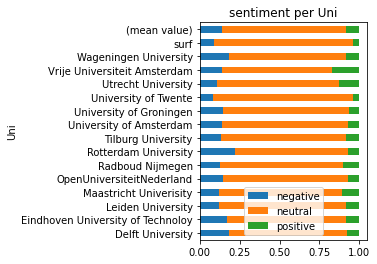

In [26]:
df_pivot = pd.pivot_table(df, index='Uni', columns=['sentiment'],values="sentences",
                          aggfunc='count')

def average_sentiment(columns):
    
    positive=columns[0]
    neutral=columns[1]
    negative=columns[2]
    total=positive+negative+neutral
    
    result=[negative/total,neutral/total,positive/total]
    
    return pd.Series(result)

columns=["positive","neutral","negative"]

sent=df_pivot.apply(average_sentiment, axis=1)

# add mean value
sent.loc['(mean value)'] = sent.mean()
sent.columns=["negative","neutral","positive"]

sent.plot.barh(stacked=True,title="sentiment per Uni",figsize=(3,4))

# Adding the columns for sentiment & metaphors

In [ ]:
##THIS TAKES TIME!! ###



df["metaphors"] = df.progress_apply(nlp.classify_metaphors, axis=1,column=text_column)
df["metaphors_n"] = df.metaphors.apply(lambda x: len(x))

df["modal"]=df.sentences.progress_apply(nlp.add_modal_info, nlp_model=nlp_model)
df["modal_n"] = df.modal.apply(lambda x: len(x))       


df["sentiment"] = df.progress_apply(nlp.roberta_sentiment, axis=1,column=text_column)
df[df["sentiment"]=="negative"][text_column]

Still, students perceive the automatic grading in this study as fair and consistent with teacher expectations.29 What insights like these can lead to is the general discussion around educational technologies and AI, where historically, under-served and underrepresented populations, including ethnic/racial minorities and linguistic minorities are not well represented by these technologies' training data.30 Teachers implementing AI systems in their classrooms and lectures therefore have questions they should ask, such as: ------------ Teacher: Questions - Do all my students have access to a device and Internet connection to do their classwork  And also at home to do their homework - Who can I go to for support with a new system like Perusall - Do I agree with the grades this system is automatically giving What do I do if I disagree What changes in curriculum will have to happen to work with this platform  - How do I communicate to my students that an algorithm will grade their work  What

In [ ]:
nlp_modal = spacy.load("en_core_web_trf")


In [398]:
sentence=df.sentences[11148]

nlp_text=nlp_model(sentence)


print(nlp_text)

for token in nlp_text:
   # print(token, token.dep_)
    if token.dep_ in ('xcomp', 'ccomp'):
        print(token)
        print(''.join(w.text_with_ws for w in token.subtree))
        if token.dep_=="aux":
            print(token.text, [(i,token.sent) for i in token.ancestors])
            print(token.text, [(i,i.pos_) for i in token.children])
      #  print(token.text, [i for i in token.set_extension])


However, he believes that we cannot simply ignore and look away from such developments.
ignore
that we cannot simply ignore and look away from such developments


In [300]:
import spacy
import spacy_transformers


def add_modal_info(sentence, nlp_model=nlp_modal):
    nlp_text=nlp_model(sentence)
    MD=[]
    for token in nlp_text:
        if token.tag_=="MD":
    
            if token.dep_!= "aux":
                print(token.text)
            MD.append(token.text)
    return MD

df.sentences[100:120].progress_apply(add_modal_info, nlp_model=nlp_model)
 



 30%|████████████████████████▉                                                          | 6/20 [00:00<00:00, 20.11it/s]

not


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.39it/s]


48581            []
19261            []
23712            []
11148    [can, not]
33671            []
48579            []
51689            []
10261            []
33668       [would]
48644            []
40827            []
29712            []
32583            []
23725         [can]
8672         [will]
248              []
29255         [can]
12826            []
6377             []
17607        [will]
Name: sentences, dtype: object

In [217]:
df.to_json(analysis.Today+"GPT3_sentiment_metaphor_modal_detection.json")

# Creating subsets

In [27]:
df.head()
#df.columns
mod_words=df[df['mod_words_n']>0]

In [28]:
df2=df.loc[mod_words_n.index,["key","Uni","date",text_column,"NoStopwords","filepath"]].join(mod_words_n)
df2.head(2)


,key,Uni,date,sentences,NoStopwords,filepath,metaphors_n,predictive_n,imperative_n,subjunctive_n,...,climate_n,capitalism_n,replacement_n,edu_n,anthropomorphism_n,learning_n,privacy_n,promise_n,discrimination_n,sentiment_n
36158,KB9PEGPE,surf,2022-03-14,https://edpb.europa.eu/system/files/2021-.,[],C:\Users\mr\Zotero\storage\KB9PEGPE\dpia-zoom-25-february-2022_0.pdf,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42464,ALDWBD7G,surf,2022-07-08,https://comproved.com/.,[],C:\Users\mr\Zotero\storage\ALDWBD7G\promises-of-ai-in-education-june-2022-def2.pdf,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df2.to_json(analysis.Today+"GPT3_Subset_predictive.json")

In [30]:
df.columns

Index(['key', 'url', 'filename', 'Uni', 'date', 'itemType', 'filepath',
       'links', 'HTML', 'sentences',
       ...
       'climate', 'capitalism', 'replacement', 'edu', 'anthropomorphism',
       'learning', 'privacy', 'promise', 'discrimination', 'sentiment_n'],
      dtype='object', length=103)

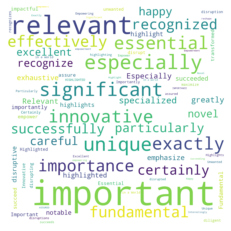

In [31]:
Key_column="hype"

WordList=df[f"{Key_column}_word"].explode().dropna().to_list()
#WordList
analysis.make_wordcloud(WordList,filename=f"{Key_column}",file_ending="jpg")

In [ ]:
W_P=[i[0] for i in Counter(WordList_P).most_common(100)]
W_N=[i[0] for i in Counter(WordList_N).most_common(100)]


set(W_P)-set(W_N)


In [164]:
WordLists

['predictive',
 'imperative',
 'subjunctive',
 'hype',
 'modal',
 'tech',
 'problem',
 'human',
 'fraud']

predictive


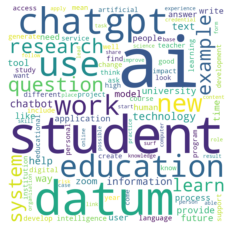

imperative


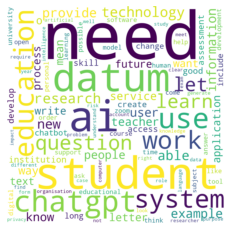

subjunctive


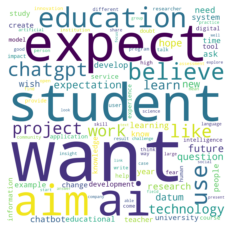

hype


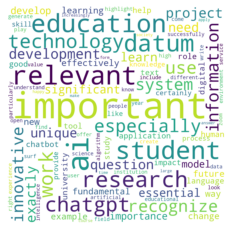

modal


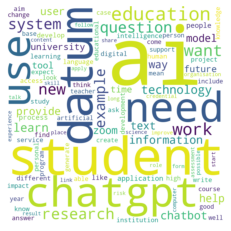

tech


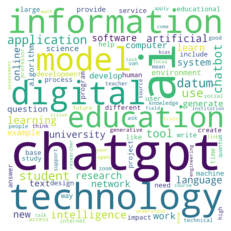

problem


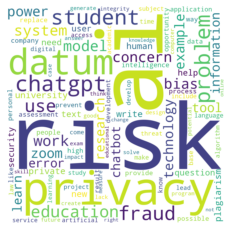

human


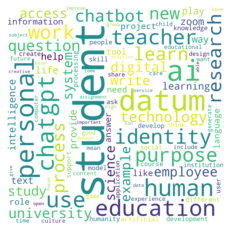

fraud


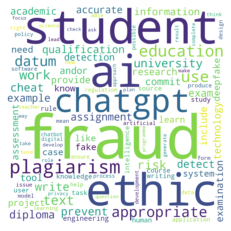

In [167]:
#imp_words=df[df['problem_n']>0]
for word in WordLists:
    print(word)
    imp_words=df[df[f'{word}_n']>0]

    WordList=imp_words.NoStopwords.to_list()
    WordList=analysis.flat(WordList)
    #WordList
    analysis.make_wordcloud(WordList,filename=f"WordCloud_{word}_co_words",file_ending="jpg")
    Counter(WordList).most_common(10)

In [ ]:
pd.DataFrame(Counter(WordList).most_common(500),columns=["word","counts"]).to_excel("positive_context.xlsx")

In [ ]:
df.set_index("date").groupby(pd.Grouper(freq=freq))["predictive_n"].apply(lambda x: sum(x) if len(x)>0 else 0)

In [234]:
#WordLists.append("metaphors")
WordLists=['predictive',
 'imperative',
 'subjunctive',
 'hype_words',
 'mod_words',
 'metaphors',"tech","human"]
WordLists

['predictive',
 'imperative',
 'subjunctive',
 'hype_words',
 'mod_words',
 'metaphors',
 'tech',
 'human']

M
tech hype subjunctive climate fraud modal promise problem edu imperative human replacement predictive capitalism anthropomorphism privacy learning discrimination metaphors 

<AxesSubplot: xlabel='date'>

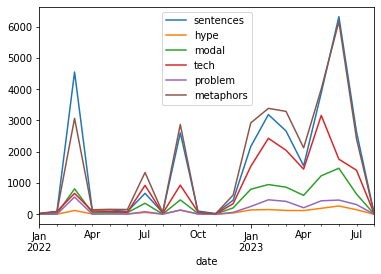

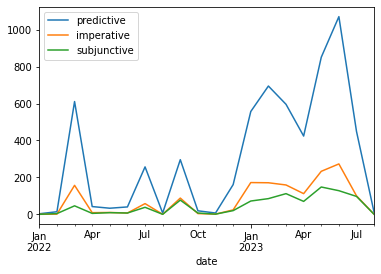

In [33]:
## Generate Timerows

freq="M"
print(freq)

hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))

timerows=df_publ
WordLists=list(set(WordLists+["metaphors"]))

for l in WordLists:
    print(l,end=" ")
    timerows[l]=hype_time[l+"_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
    
timerows[[text_column,"hype","modal","tech","problem","metaphors"]][timerows.index>pd.Timestamp("2022-1-1")].plot()

#secondary_y=True
timerows[["predictive","imperative","subjunctive"]][timerows.index>pd.Timestamp("2022-1-1")].plot()

<AxesSubplot: xlabel='date'>

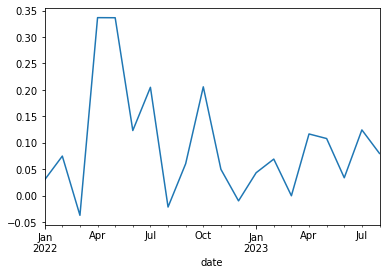

In [35]:
freq="M"

def sentiment_time(x):
    pos=sum(x=="positive")
    neg=sum(x=="negative")
    neu=sum(x=="neutral")
    total=pos+neg+neu
    rel_sent=(pos-neg)/(neu+0.000001)
    return rel_sent

hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))

timerows["sentiment"]=hype_time["sentiment"].apply(sentiment_time)
timerows["sentiment"][timerows.index>pd.Timestamp("2022-1-1")].plot()


In [36]:
timerows.fillna(0.000)
for c in timerows.columns[1:]:
    print(c)
    timerows[c+"-rel"]=timerows[text_column]/timerows[c].fillna(0)

tech
hype
subjunctive
climate
fraud
modal
promise
problem
edu
imperative
human
replacement
predictive
capitalism
anthropomorphism
privacy
learning
discrimination
metaphors
sentiment


<AxesSubplot: xlabel='date'>

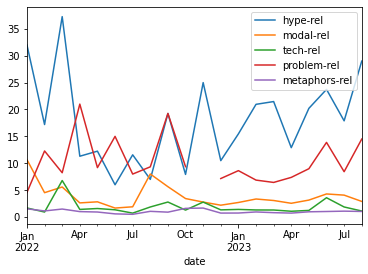

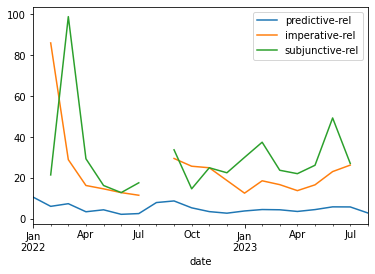

In [37]:
timerows[["hype-rel","modal-rel","tech-rel","problem-rel","metaphors-rel"]][timerows.index>pd.Timestamp(2022,1,1)].fillna(0).plot()
timerows[["predictive-rel","imperative-rel","subjunctive-rel"]][timerows.index>pd.Timestamp(2022,1,1)].fillna(0).plot()

In [38]:
HypeMax=timerows[timerows["hype"]==timerows["hype"].max()]

HypeMaxDateTime=HypeMax.index[0]
HypeMax

,sentences,tech,hype,subjunctive,climate,fraud,modal,promise,problem,edu,...,human-rel,replacement-rel,predictive-rel,capitalism-rel,anthropomorphism-rel,privacy-rel,learning-rel,discrimination-rel,metaphors-rel,sentiment-rel
date,,,,,,,,,,,,,,,,,,,,,
2023-06-30,6315,1761,266,128,45,158,1472,117,455,1293,...,6.819654,32.055838,5.896359,8.98293,23.920455,14.095982,11.54479,65.103093,1.026162,185674.020651


In [ ]:
# DateOffset adds days
df[df.date>=HypeMax.index[0]][df.date<=HypeMaxDateTime+ pd.DateOffset(7)].filepath.drop_duplicates()

# Named entity recognition of hype / mod sentences

- PERSON:      People, including fictional.
- NORP:        Nationalities or religious or political groups.
- FAC:         Buildings, airports, highways, bridges, etc.
- ORG:         Companies, agencies, institutions, etc.
- GPE:         Countries, cities, states.
- LOC:         Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
- EVENT:       Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW:         Named documents made into laws.
- LANGUAGE:    Any named language.
- DATE:        Absolute or relative dates or periods.
- TIME:        Times smaller than a day.
- PERCENT:     Percentage, including ”%“.
- MONEY:       Monetary values, including unit.
- QUANTITY:    Measurements, as of weight or distance.
- ORDINAL:     “first”, “second”, etc.
- CARDINAL:    Numerals that do not fall under another type.

In [182]:
d(150)

example=df.dropna(subset="modal").sort_values("hype_words_n", ascending=False)
#example=example.loc[example.hype_words_n>5,["hype_n",text_column,"filepath"]] # minimum 1 hypeword
print(len(example))
#example.to_csv("2023-08-03_hype_paragraphs.csv")
example=example[["sentences","modal"]].head(10)


7917


,sentences,modal
42167,Users ask questions that are then passed through these models; the final output is then constructed as a greeting and then the relevant informatio...,"[can, may]"
10412,Can you discuss any particularly innovative or groundbreaking projects currently being undertaken at the centre One of the notable projects is the...,"[Can, aims]"
10855,"This shift has offered the opportunity to expand and grow both research and educational practice in many novel directions, but in these increasing...",[need]
12200,"It is clear that as technologies hold the promise of significantly transforming our society in the years to come, we must learn how to use these t...",[must]
833,"Text generation can play a major part in this problem; however, text generation models still suffer from a major problem: Hallucinations, adding u...","[can, should]"
...,...,...
49098,"exactly and is it desirable at all. But in any case, data must be available.",[must]
49832,"is already possible, but what applications are still to come. This will certainly have an impact.",[will]
1005,"Findings: Most tested relationships turned out to be non-significant and but one, no hypotheses could be confirmed.",[could]
37942,The HOSA project aims to define an architecture for sector services that are important for strategic.,[aims]


In [ ]:

from thinc.api import set_gpu_allocator, require_gpu
nlp_model = spacy.load("en_core_web_trf") # thanks to Martin L. for advising me on this.


In [ ]:

        for c in token.children:
            if c.pos_=="PART":
                p=c.text
            if c.pos_=="AUX":
                modal[0]=c.text # e.g. should
                modal[1]=c.text+p+token.text
                return modal
            
                for token in nlp_text:
        modal=modality(token)
        if modal:
            modal_info.append(modal)
    return modal_info

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.71it/s]


In [201]:
d(400)
example[["sentences","modal_info"]]

,sentences,modal_info
42167,"Users ask questions that are then passed through these models; the final output is then constructed as a greeting and then the relevant information from the syllabus.37 The virtual agent uses semantic information processing technology to reply to human-typed questions.38 Importantly, Jill Watson does not and cannot learn from student responses or feedback in their interactions with (outside) u...",[may]
10412,"Can you discuss any particularly innovative or groundbreaking projects currently being undertaken at the centre One of the notable projects is the EUR Smart Campus Project , Opens external which aims to utilise data and digitalisation to create awareness around sustainability and human well-being.",[can]
10855,"This shift has offered the opportunity to expand and grow both research and educational practice in many novel directions, but in these increasingly self-directed learning environments the need for students to be able to effectively self-regulate their learning is more important than ever.",[]
12200,"It is clear that as technologies hold the promise of significantly transforming our society in the years to come, we must learn how to use these to enjoy their advantages avoiding unwanted situations.",[must]
833,"Text generation can play a major part in this problem; however, text generation models still suffer from a major problem: Hallucinations, adding unimportant / irrelevant / fictitious information to texts that should not be there..","[can, should]"
22653,"The study highlights the need for caution when using ChatGPT for safety-related information and expert verification, as well as the need for ethical considerations and safeguards to ensure users understand the limitations and receive appropriate advice, especially in low- and middle-income countries.",[]
12839,"The consequences of this biased decision-making were significant, as it resulted in many families losing access to essential benefits that they needed to support their children, leading to financial difficulties and accompanying mental hardships.",[]
17920,"This should raise the safety level of batteries significantly, e. g. , when used in aircraft and cars, given that flammable liquids are still being used at present.",[should]
9694,Programme 11:30 – 11:50 – What is AI What are the recent developments and why is it relevant By Prof dr. Antal van den Bosch... external link 12:00 – 12:20 – What are the limitations of ChatGPT What exactly can it not do By Prof. dr. ir.,[can]
12855,"Females re-offend at a significantly lower rate than expected, while males re-offend at a significantly higher rate than expected..",[]


In [100]:

AUX=[((t.text,[( child.dep_, child.text) for child in t.children], t.text)) for t in nlp_text if t.dep_=="root"]

AUX

[]

In [ ]:
import spacy
import spacy_transformers

from thinc.api import set_gpu_allocator, require_gpu
NER = spacy.load("en_core_web_trf") # thanks to Martin L. for advising me on this.

RAW_text=" ".join(example[text_column].to_list())

# THIS Takes long
t()
NER_text=NER(RAW_text)
t()
##

Orgs=[word.text for word in NER_text.ents if word.label_=="ORG"]
Persons=[word.text for word in NER_text.ents if word.label_=="PERSON"]
Law=[word.text for word in NER_text.ents if word.label_=="LAW"]
Event=[word.text for word in NER_text.ents if word.label_=="EVENT"] # ART , WORK_OF_ART

from collections import Counter
Counter(Orgs).most_common(10)
n,c=zip(*(Counter(Orgs).most_common(10)))

n

In [ ]:
Counter(Orgs).most_common(20)

In [ ]:
## Sentences with Hypewords & Organisations by dict.
from collections import defaultdict
Orgs_dict=defaultdict(list)
{Orgs_dict[word.text].append(word.sent) for word in NER_text.ents if word.label_=="ORG"}
Orgs_dict={k:list(set(v)) for k, v in Orgs_dict.items()}

Orgs_dict[n[0]][:2]

In [ ]:
Organizations=pd.DataFrame(Counter(Orgs).most_common(1000))
Organizations.columns=["name","counts"]
Organizations.to_json("2023-08-02_Organisations.json")
organisations=Organizations.name.to_list()


In [ ]:
#df.pure_text.apply(hype.hype_sentence,keys=[" een "]).dropna()

In [ ]:
Organizations=pd.read_json("2023-08-01_Organisations.json")

In [ ]:
Organizations[:20].plot.barh(x="name")


In [ ]:
# Manually improve the NER (lists not updated for the transformer)
manually_added_organisations=["Centre for Language and Speech Technology","Computational Linguistics Group","Leiden Law Park","ICRES","GRN","CLST","AiPact" , "AI MAPS" , "ALGOSOC Opens","MAGPIE Opens"]
Non_organisations=["ation","Ion","IS","state","the Netherlands","gather","NL","Conference","risico","Covid"]
AI_terms=["ict","LLM","data","GPT","ChatGPT","chatGPT","Deep Learning","GPT-3","AI in education","Generative AI","Chat GPT"]
Uni_terms=["Edu","Education","Univers","Faculty","the Faculty of","Board","University","PhD","the Faculty of Science","Education and"]

organisations=list(set(organisations+manually_added_organisations)-set(Non_organisations+AI_terms+Uni_terms))

organisations=[i.replace("the ","") for i in organisations]

In [ ]:
# finding Orgas in sentences

Orks=df[["Uni",text_column]]
Orks.loc[:,["organisations"]]=Orks[text_column].apply(hype.keyword_return,keys=organisations)

Orks=Orks.explode("organisations").loc[Orks.organisations.dropna().index,["Uni","organisations"]]

Orks.value_counts()[:10]

In [ ]:
import networkx as nx
G = nx.DiGraph()
TuppleList=list(Orks.dropna().itertuples(index=False, name=None))
G.add_edges_from(TuppleList, source="Uni", target="organisations")
#G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=False)
nx.write_gexf(G,"Organisations.gexf")

Centrality=pd.DataFrame(nx.in_degree_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)
Centrality.columns=["in_degree_centrality"]
Uni_terms=["Humanities","Levels","the Faculty of Science","Board of Examiners","the Board of Examiners","Executive Board","Examination Board","Electrical Engineering, Mathematics","Studium Generale","Council","PHD","the Examinations Board"]

Centrality.head(15).plot.barh(figsize=(3,5))

# Word dependency

In [194]:
subjects=[]
subjects2=[]
objects=[]
verbs=[]
verbs2=[]
for token in NER_text:
    if token.dep_=="nsubj":
        subjects.append(token.lemma_)
        subjects2.append(", ".join([child.lemma_ for child in token.children])+" "+token.lemma_)
        
    if token.dep_=="pobj" or token.dep_=="dobj":
        objects.append(token.text)
        
    if token.dep_=="ROOT":
        verbs.append(token.text)
        SUB="education"
        if SUB in [child.lemma_ for child in token.children]:
            subj=" ".join([child.lemma_ for child in token.children if child.lemma_==SUB])
            obj=", ".join([child.text for child in token.children if child.dep_=="pobj" or child.dep_=="dobj"])
            obj=", ".join([child.text for child in token.children if child])

            verbs2.append(subj+ " " +token.text + " " + obj)    

from collections import Counter
A=Counter(subjects2).most_common(20)

B=Counter(objects).most_common(20)

C=Counter(verbs).most_common(20)
print(A)
print(B)
print(C)

NameError: name 'NER_text' is not defined

In [ ]:
#wordcontext of education

for token in NER_text[:1000]:
    if token.text=="education":
        print("\n",token.text)
        print(token.sent)

In [ ]:
Counter(verbs2).most_common(15)

In [ ]:
Subjects=[i for i in subjects2]
a,b=zip(*Counter(subjects).most_common(20))

from matplotlib import pyplot as plt
plt.title("most common subjects")
plt.barh(a, b)


# Hype-word & Mod-word statistics per university

In [ ]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="key").value_counts("Uni"), 
                     text_column:df.value_counts("Uni"),
                    "mod_words":df.groupby("Uni")["mod_words_n"].sum()})

Counts["mean mod-words"]=Counts["mod_words"]/Counts[text_column]

Counts.sort_values("mean mod-words", ascending=False)

In [ ]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="key").value_counts("Uni"), 
                     text_column:df.value_counts("Uni"),
                    "hype_words":df.groupby("Uni")["hype_words_n"].sum()})

Counts["mean hype_words"]=Counts["hype_words"]/Counts[text_column]
Counts.sort_values("mean hype_words", ascending=False)

# Does translation increase the share of hype words? // Is Dutch more hyping?

In [ ]:
pd.set_option('display.max_colwidth', 300)

df.loc[df.Uni=="surf",[text_column]].head(10)

# Use of words over time

In [231]:
from collections import Counter


keyWords="chatgpt,education,chatbot,university,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"
keyWords="education,chatbot,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"

keyWords=keyWords.split(",")
print(keyWords)

group=df.set_index("date").groupby(pd.Grouper(freq='M'))["NoStopwords"].sum()

Wordyear={}
Wordyear_number={}
Wordyear_only={}

for i, row in group.items():
    
    #print(i,row)
    if type(row)==list:
        
        ## filter ROW for interesting key-words:
        row=[i for i in row if i in keyWords]
        
        c=Counter(row).most_common(5)
        
      #  c_exact=[(i[0],i[1]/len(group)) for i in c]
        
        
        
        c_number=[(i[0],round(int(i[1])/len(row),2)) for i in c]
        
        # Counter results in percent.
        c=[(i[0],str(round(i[1]/len(row)*100,2))+"%") for i in c]
        

        c_only=[i[0] for i in c]


        Wordyear[str(i)]=c
        Wordyear_number[str(i)]=c_number
        Wordyear_only[str(i)]=c_only
        
        
        
    #print(c,"\n")
    
CountDF=pd.DataFrame.from_dict(Wordyear, orient='index').T


CountDF.T[CountDF.T.index>"2022-06-01"]

['education', 'chatbot', 'create', 'write', 'produce', 'answer', 'tool', 'human', 'skill', 'knowledge', 'bias', 'assignment', 'intelligence', 'artificial', 'test', 'evaluate', 'assessment', 'plagiarism']


,0,1,2,3,4
2022-06-30 00:00:00,"(chatbot, 54.24%)","(human, 13.56%)","(education, 10.17%)","(answer, 6.78%)","(write, 3.39%)"
2022-07-31 00:00:00,"(education, 26.68%)","(answer, 10.34%)","(intelligence, 9.38%)","(tool, 8.17%)","(write, 7.21%)"
2022-08-31 00:00:00,"(chatbot, 62.5%)","(test, 25.0%)","(create, 12.5%)",None,None
2022-09-30 00:00:00,"(education, 69.78%)","(create, 4.56%)","(test, 4.56%)","(knowledge, 3.84%)","(assessment, 2.64%)"
2022-10-31 00:00:00,"(knowledge, 33.33%)","(chatbot, 19.05%)","(artificial, 9.52%)","(intelligence, 9.52%)","(assessment, 9.52%)"
2022-11-30 00:00:00,"(chatbot, 100.0%)",None,None,None,None
2022-12-31 00:00:00,"(write, 21.11%)","(artificial, 9.44%)","(answer, 9.44%)","(intelligence, 8.89%)","(knowledge, 7.22%)"
2023-01-31 00:00:00,"(education, 15.91%)","(chatbot, 8.91%)","(write, 8.67%)","(intelligence, 8.31%)","(human, 7.96%)"
2023-02-28 00:00:00,"(education, 16.17%)","(intelligence, 11.01%)","(artificial, 8.94%)","(tool, 7.8%)","(write, 7.22%)"
2023-03-31 00:00:00,"(education, 18.02%)","(tool, 9.91%)","(write, 8.36%)","(answer, 7.93%)","(assessment, 7.16%)"


In [ ]:
CountDF=pd.DataFrame.from_dict(Wordyear_only, orient='index').T
CountDF.T[CountDF.T.index>"2022-10-01"]

# Words in context & Word-Graph analysis

In [ ]:
SearchTerm="Google" 
Result=df[df["sentences"].apply(lambda x: SearchTerm in x)]["sentences"]
d(5000)
Result.head(5)

In [ ]:
#This cell allows to read the words before and after a search_word. You can change the searchword & the size of the context.
@interact(search_word="education",words_before=(0,10),words_after=(0,10))
def text_context(column=["NoStopwords","sentences"],search_word="education",words_before=1,words_after=1):
    df[column].dropna().apply(analysis.Keyword_context,search_word=search_word.lower(),n_examples=1000,context=(words_before,words_after))


In [ ]:
# WORD _GRAPH ANALYSIS

G=analysis.Word_NetworkGen(df,n=500,column="NoStopwords")
G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=True)
#G2=G
analysis.writeNetworkHTML(G2,view=False)
print("see the network: The_network.html")

In [ ]:
import networkx as nx
nx.write_gexf(G, "NoStopwords.gexf")

Centrality=pd.DataFrame(nx.closeness_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)

Centrality.columns=["closeness-Centrality_per_sentence"]
Centrality.head(10)

# Link Analysis 

In [ ]:
df.columns

In [ ]:
import networkx as nx

#df=pd.read_json("2023-02-06_Zotero_AI_nlp_en2.json")
links=df[["url","links"]].drop_duplicates(subset="url").explode("links")

In [ ]:
def domain_From_url(url):
    if isinstance(url,str):
        domain=url.replace("https://","").replace("http://","").replace("www.","").split("/")[0].lstrip(".")
        domain=domain.rsplit("@",1)[-1].rsplit("%20",1)[-1]
        if domain.count(".")>1:
            domain=".".join(domain.rsplit(".",2)[-2:])

        if "." in domain:
            return domain
    
links["source"]=links.url.apply(domain_From_url)
links["target"]=links.links.apply(domain_From_url).reindex()

In [ ]:
edgelist

In [ ]:
links=links.dropna(subset="target").dropna(subset="source")
#links=links[~links["url"].apply(lambda x: "linkedin.com" in x)]
edgelist=(zip(links["source"], links["target"]))

links[links["source"]==None]
G = nx.from_edgelist(edgelist)
nx.write_gexf(G,"Links.gexf")
Link_Centrality=pd.DataFrame(nx.closeness_centrality(G),index=[0]).T.sort_values(ascending=False, by=0)
Link_Centrality.columns=["Centrality"]
Link_Centrality.head(10)

In [ ]:
edgelist=(zip(links["source"], links["target"]))
edges=list(edgelist)

In [ ]:
from collections import Counter
pd.DataFrame(Counter(edges).most_common(15))

In [ ]:
[i for i in links if "michelklein.nl" in i]

In [ ]:
links=df.links.to_list()
links=[list(set(l))for l in links if type(l)==list]
links=[i for s in links for i in s if i!=None]
domains=[domain_From_url(i) for s in links for i in s if i!=None]

In [ ]:

from collections import Counter
a_counter = Counter(links)
most_common = a_counter.most_common(15)
most_common

In [ ]:
links=df.linkUrl.to_list()